# $\epsilon$-greedy

In [3]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import pandas as pd

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The 10-armed Testbed

In [33]:
key = random.PRNGKey(3141)

key_bandit, key_sample = random.split(key, 2)
n_bandits = 10
true_values = random.normal(key_bandit, (n_bandits,))
true_values

DeviceArray([-0.8827954 , -0.8210903 , -0.8111066 ,  0.01464275,
              0.23943917, -1.1053445 ,  0.8371419 ,  1.3699214 ,
             -0.7999021 , -0.19373448], dtype=float32)

In [70]:
n_samples = 5000
bandit_samples = random.normal(key_sample, (n_bandits, n_samples)) + true_values[:, None]
bandit_samples.shape

(10, 5000)

In [71]:
bandit_samples = pd.DataFrame(bandit_samples.T).melt()
bandit_samples = bandit_samples.rename({"variable":"action", "value":"reward"}, axis=1)

(-4.0, 4.0)

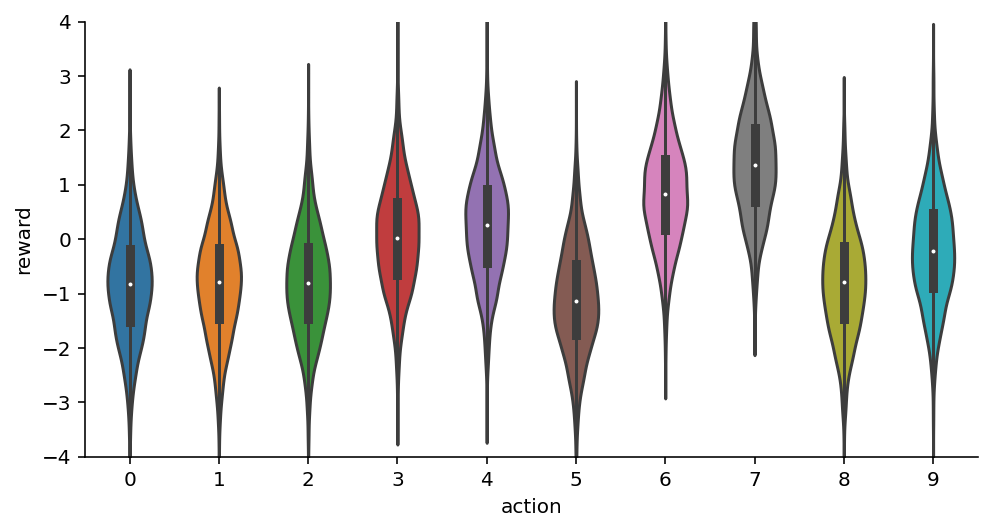

In [75]:
plt.subplots(figsize=(8, 4))
sns.violinplot(x="action", y="reward", data=bandit_samples, width=0.5)
plt.ylim(-4, 4)

## $\epsilon$-greedy method

$$
    Q_t(a) := 
$$

In [83]:
import numpy as np

In [182]:
num_steps = 1000

In [266]:
Qt = jnp.zeros(n_bandits)

In [267]:
%%time

eps = 0.1
bandits = jnp.arange(n_bandits)
key_step = random.PRNGKey(315)
total_reward = 0.0

num_visits = jnp.zeros(n_bandits)
rewards = jnp.zeros(n_bandits)
reward_hist = jnp.zeros(num_steps)

for step in range(num_steps):
    key_action, key_reward, key_step = random.split(key_step, 3)
    
    if jax.random.uniform(key_action) < eps:
        action = random.choice(key_action, bandits)
    else:
        greedy_actions, *_ = jnp.where(Qt.max() == Qt)
        action = random.choice(key_action, greedy_actions).item()
        
    reward = random.normal(key_reward) + true_values[action]
    
    new_reward = rewards[action] + reward
    num_visits = jax.ops.index_update(num_visits, action, num_visits[action] + 1)
    rewards = jax.ops.index_update(rewards, action, new_reward)

    total_reward += new_reward
    reward_hist = jax.ops.index_update(reward_hist, step, reward)
    
    Qt = num_visits * rewards / jnp.clip(num_visits, 1)

CPU times: user 32.4 s, sys: 11.3 s, total: 43.7 s
Wall time: 17.2 s


In [334]:
def take_greedy(state, key):
    num_visits, rewards = state
    key_action, key_reward = random.split(key)
    
    Qt = num_visits * rewards / jnp.clip(num_visits, 1)
    take_greedy = (jax.random.uniform(key_action) < eps) * 1.0
    
    map_choice = Qt.max() == Qt
    prob_choice_Q = map_choice / map_choice.sum()
    greedy_actions = random.choice(key_action, bandits, p=prob_choice_Q)
    
    action = take_greedy * random.choice(key_action, bandits) + (1 - take_greedy) * greedy_actions
    reward = random.normal(key_reward) + true_values[action.astype(int)]
    
    num_visits = num_visits + jax.nn.one_hot(action, n_bandits)
    rewards = rewards + jax.nn.one_hot(action, n_bandits) * reward
    
    return (num_visits, rewards), reward

In [338]:
key = random.PRNGKey(315)
keys = random.split(key, num_steps)
num_visits = jnp.zeros(n_bandits)
rewards = jnp.zeros(n_bandits)

In [339]:
%%time
(num_visits_final, rewards_final), reward = jax.lax.scan(take_greedy, (num_visits, rewards), keys)

CPU times: user 3.07 ms, sys: 0 ns, total: 3.07 ms
Wall time: 1.31 ms


In [340]:
num_visits_final

DeviceArray([  5.,   8.,   8.,   7.,  13.,   5.,  10., 912.,  18.,  14.],            dtype=float32)

In [344]:
eps_greedy_sims = jax.vmap(lambda key: jax.lax.scan(take_greedy, (num_visits, rewards), random.split(key, num_steps)))

In [346]:
%%time
n_sims = 1500
keys = random.split(key, n_sims)
_, reward_sims = eps_greedy_sims(keys)

CPU times: user 1.96 s, sys: 0 ns, total: 1.96 s
Wall time: 1.26 s


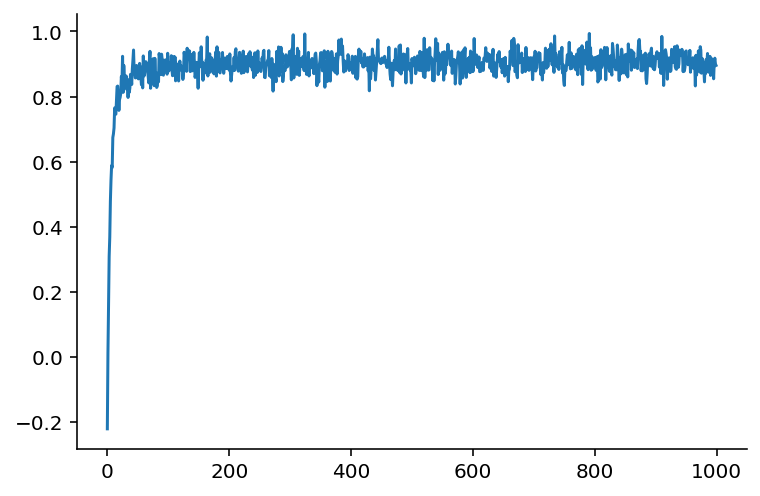

In [348]:
plt.plot(reward_sims.mean(axis=0))